In [32]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [33]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_size = 120

lr = 0.001

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        activation_1 = F.relu(self.fc1(x))
        x = self.fc2(activation_1)
        return x, torch.sign(activation_1)
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc1): Linear (3072 -> 120)
  (fc2): Linear (120 -> 10)
)


In [35]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        bins = range(0, hidden_layer_size)
        indexes1 = np.random.choice(self.train_activations.shape[0], 10000)
        indexes2 = np.random.choice(self.train_activations.shape[0], 10000)
        
        distances = np.abs(self.train_activations[indexes1] - self.train_activations[indexes2]).sum(1)
        plt.hist(distances, bins, label='Train Activations')
        
        indexes1 = np.random.choice(self.test_activations.shape[0], 10000)
        indexes2 = np.random.choice(self.test_activations.shape[0], 10000)
        
        distances = np.abs(self.test_activations[indexes1] - self.train_activations[indexes2]).sum(1)
        plt.hist(distances, bins, label='Test Activations')
        
        plt.legend()
        plt.title('Histogram of distances of activation patterns')
        plt.show()
        # Here sample and compute histogram of distances.
        # Then Matrix with std of distances between classes.
        

In [36]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [37]:
if cuda:
    model.cuda()
    criterion.cuda()

In [38]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations.cpu().data.numpy(), target.cpu().data.numpy())
    for batch_idx, (data, target) in enumerate(testloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.test_add(activations.cpu().data.numpy(), target.cpu().data.numpy())
        
    metrics.print_metrics()
    return metrics

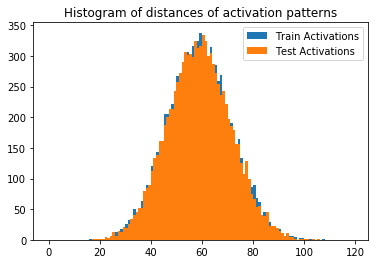

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.268882
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.119610
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.969355
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.870536
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.533229
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.310236
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.679639
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.124205

Test set: Average loss: 1.5691, Accuracy: 4402/10000 (44%)



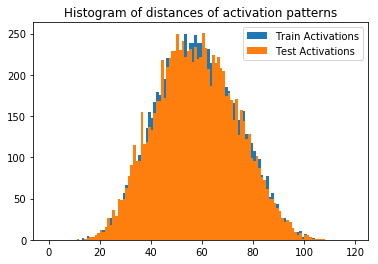

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.734630
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.585999
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.619494
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.666748
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.475594
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.729126
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.504914
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.301273

Test set: Average loss: 1.4878, Accuracy: 4824/10000 (48%)



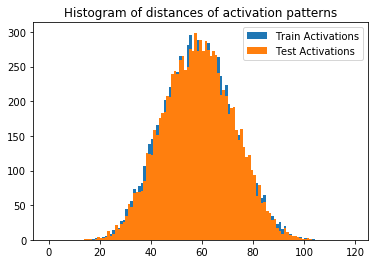

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.477941
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.765597
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.699655
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.862210
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.094999
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.056668
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.622036
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.541510

Test set: Average loss: 1.4295, Accuracy: 4947/10000 (49%)



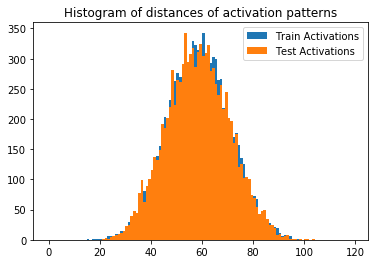

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.171575
Train Epoch: 4 [6400/50000 (13%)]	Loss: 0.774642
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.124072
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.110193
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.598273
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.707794
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.078237
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.376464

Test set: Average loss: 1.4020, Accuracy: 5016/10000 (50%)



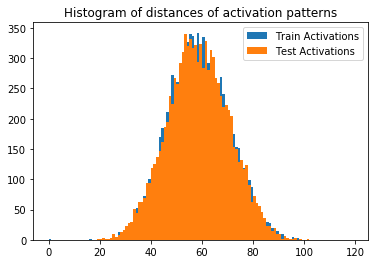

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.184789
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.319447
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.434628
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.478548
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.891667
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.317675
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.193885
Train Epoch: 5 [44800/50000 (90%)]	Loss: 1.273497

Test set: Average loss: 1.3854, Accuracy: 5130/10000 (51%)



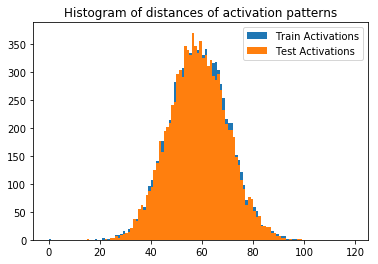

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.637976
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.358556
Train Epoch: 6 [12800/50000 (26%)]	Loss: 1.453567
Train Epoch: 6 [19200/50000 (38%)]	Loss: 0.938805
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.222120
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.054490
Train Epoch: 6 [38400/50000 (77%)]	Loss: 0.825229
Train Epoch: 6 [44800/50000 (90%)]	Loss: 0.924552

Test set: Average loss: 1.3997, Accuracy: 5090/10000 (51%)



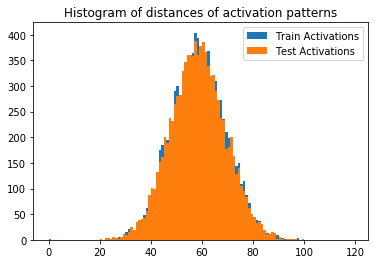

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.970074
Train Epoch: 7 [6400/50000 (13%)]	Loss: 1.085974
Train Epoch: 7 [12800/50000 (26%)]	Loss: 1.655952
Train Epoch: 7 [19200/50000 (38%)]	Loss: 1.051936
Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.127403
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.449013
Train Epoch: 7 [38400/50000 (77%)]	Loss: 1.583046
Train Epoch: 7 [44800/50000 (90%)]	Loss: 1.034994

Test set: Average loss: 1.3800, Accuracy: 5175/10000 (52%)



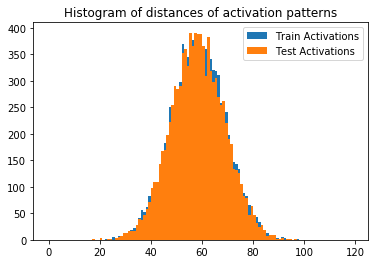

Train Epoch: 8 [0/50000 (0%)]	Loss: 1.160528
Train Epoch: 8 [6400/50000 (13%)]	Loss: 1.497983
Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.058764
Train Epoch: 8 [19200/50000 (38%)]	Loss: 0.609902
Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.265551
Train Epoch: 8 [32000/50000 (64%)]	Loss: 1.021079
Train Epoch: 8 [38400/50000 (77%)]	Loss: 1.281558
Train Epoch: 8 [44800/50000 (90%)]	Loss: 1.466362

Test set: Average loss: 1.3825, Accuracy: 5168/10000 (52%)



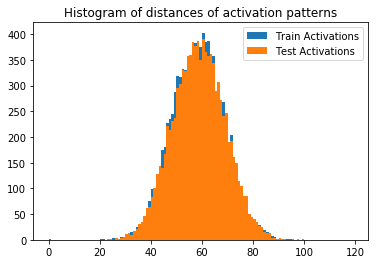

Train Epoch: 9 [0/50000 (0%)]	Loss: 1.414665
Train Epoch: 9 [6400/50000 (13%)]	Loss: 0.960510
Train Epoch: 9 [12800/50000 (26%)]	Loss: 0.983316
Train Epoch: 9 [19200/50000 (38%)]	Loss: 1.110542
Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.309622
Train Epoch: 9 [32000/50000 (64%)]	Loss: 1.175608
Train Epoch: 9 [38400/50000 (77%)]	Loss: 1.472531
Train Epoch: 9 [44800/50000 (90%)]	Loss: 1.030231

Test set: Average loss: 1.3729, Accuracy: 5156/10000 (52%)



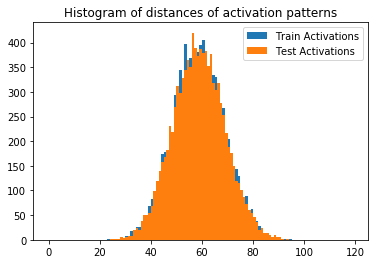

Train Epoch: 10 [0/50000 (0%)]	Loss: 1.796846
Train Epoch: 10 [6400/50000 (13%)]	Loss: 1.140433
Train Epoch: 10 [12800/50000 (26%)]	Loss: 1.267100
Train Epoch: 10 [19200/50000 (38%)]	Loss: 0.616503
Train Epoch: 10 [25600/50000 (51%)]	Loss: 1.287647
Train Epoch: 10 [32000/50000 (64%)]	Loss: 1.200233
Train Epoch: 10 [38400/50000 (77%)]	Loss: 1.015144
Train Epoch: 10 [44800/50000 (90%)]	Loss: 0.797478

Test set: Average loss: 1.3900, Accuracy: 5247/10000 (52%)



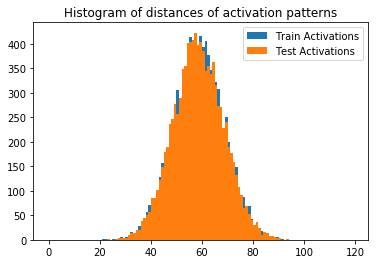

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.894065
Train Epoch: 11 [6400/50000 (13%)]	Loss: 1.445589
Train Epoch: 11 [12800/50000 (26%)]	Loss: 1.433974
Train Epoch: 11 [19200/50000 (38%)]	Loss: 1.401931
Train Epoch: 11 [25600/50000 (51%)]	Loss: 1.042928
Train Epoch: 11 [32000/50000 (64%)]	Loss: 0.742535
Train Epoch: 11 [38400/50000 (77%)]	Loss: 0.387856
Train Epoch: 11 [44800/50000 (90%)]	Loss: 1.070022

Test set: Average loss: 1.3835, Accuracy: 5234/10000 (52%)



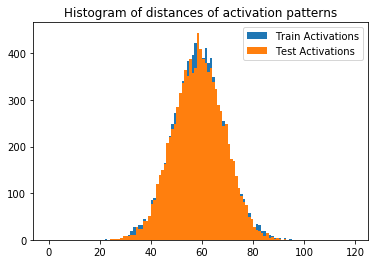

Train Epoch: 12 [0/50000 (0%)]	Loss: 1.333002
Train Epoch: 12 [6400/50000 (13%)]	Loss: 0.955312
Train Epoch: 12 [12800/50000 (26%)]	Loss: 1.254871
Train Epoch: 12 [19200/50000 (38%)]	Loss: 0.643848
Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.996368
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.873437
Train Epoch: 12 [38400/50000 (77%)]	Loss: 1.463899
Train Epoch: 12 [44800/50000 (90%)]	Loss: 1.090067

Test set: Average loss: 1.4018, Accuracy: 5159/10000 (52%)



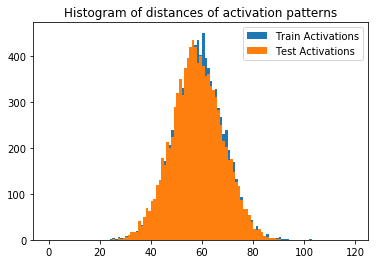

Train Epoch: 13 [0/50000 (0%)]	Loss: 1.453257
Train Epoch: 13 [6400/50000 (13%)]	Loss: 0.933807
Train Epoch: 13 [12800/50000 (26%)]	Loss: 1.107631
Train Epoch: 13 [19200/50000 (38%)]	Loss: 1.219792
Train Epoch: 13 [25600/50000 (51%)]	Loss: 0.912065
Train Epoch: 13 [32000/50000 (64%)]	Loss: 1.063752
Train Epoch: 13 [38400/50000 (77%)]	Loss: 0.990518
Train Epoch: 13 [44800/50000 (90%)]	Loss: 1.723078

Test set: Average loss: 1.4021, Accuracy: 5179/10000 (52%)



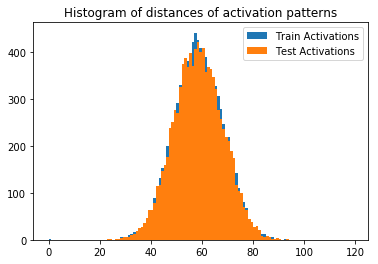

Train Epoch: 14 [0/50000 (0%)]	Loss: 1.149196
Train Epoch: 14 [6400/50000 (13%)]	Loss: 1.556577
Train Epoch: 14 [12800/50000 (26%)]	Loss: 0.622297
Train Epoch: 14 [19200/50000 (38%)]	Loss: 1.229081
Train Epoch: 14 [25600/50000 (51%)]	Loss: 1.060570
Train Epoch: 14 [32000/50000 (64%)]	Loss: 1.532252
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.793252
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.856096

Test set: Average loss: 1.4114, Accuracy: 5152/10000 (52%)



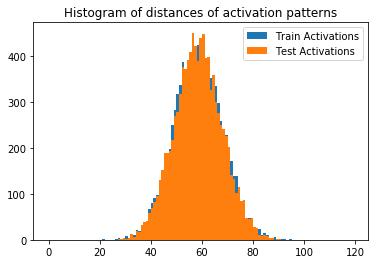

Train Epoch: 15 [0/50000 (0%)]	Loss: 1.298970
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.744799
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.760268
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.986356
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.616612
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.862323
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.625622
Train Epoch: 15 [44800/50000 (90%)]	Loss: 1.867815

Test set: Average loss: 1.4228, Accuracy: 5147/10000 (51%)



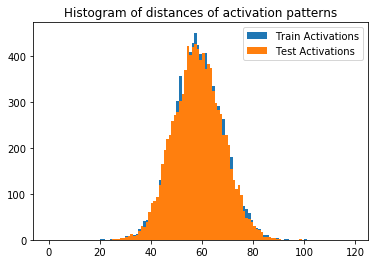

Train Epoch: 16 [0/50000 (0%)]	Loss: 0.798889
Train Epoch: 16 [6400/50000 (13%)]	Loss: 0.927056
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.635276
Train Epoch: 16 [19200/50000 (38%)]	Loss: 1.065538
Train Epoch: 16 [25600/50000 (51%)]	Loss: 1.085537
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.944753
Train Epoch: 16 [38400/50000 (77%)]	Loss: 0.908843
Train Epoch: 16 [44800/50000 (90%)]	Loss: 1.136603

Test set: Average loss: 1.4484, Accuracy: 5169/10000 (52%)



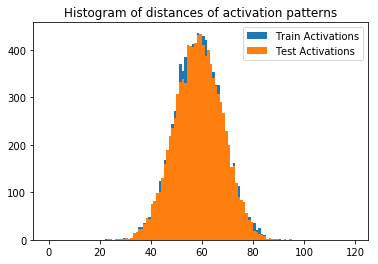

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.519085
Train Epoch: 17 [6400/50000 (13%)]	Loss: 0.921058
Train Epoch: 17 [12800/50000 (26%)]	Loss: 0.945338
Train Epoch: 17 [19200/50000 (38%)]	Loss: 0.911407
Train Epoch: 17 [25600/50000 (51%)]	Loss: 0.720794
Train Epoch: 17 [32000/50000 (64%)]	Loss: 0.960628
Train Epoch: 17 [38400/50000 (77%)]	Loss: 0.987188
Train Epoch: 17 [44800/50000 (90%)]	Loss: 0.864475

Test set: Average loss: 1.4543, Accuracy: 5146/10000 (51%)



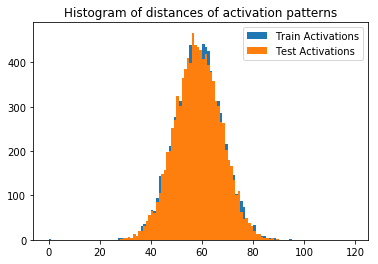

Train Epoch: 18 [0/50000 (0%)]	Loss: 0.737413
Train Epoch: 18 [6400/50000 (13%)]	Loss: 0.681915
Train Epoch: 18 [12800/50000 (26%)]	Loss: 0.630087
Train Epoch: 18 [19200/50000 (38%)]	Loss: 1.002042
Train Epoch: 18 [25600/50000 (51%)]	Loss: 1.200285
Train Epoch: 18 [32000/50000 (64%)]	Loss: 0.829756
Train Epoch: 18 [38400/50000 (77%)]	Loss: 1.242586
Train Epoch: 18 [44800/50000 (90%)]	Loss: 1.425132

Test set: Average loss: 1.4478, Accuracy: 5180/10000 (52%)



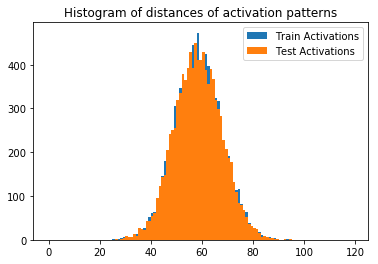

Train Epoch: 19 [0/50000 (0%)]	Loss: 1.262457
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.682747
Train Epoch: 19 [12800/50000 (26%)]	Loss: 1.240107
Train Epoch: 19 [19200/50000 (38%)]	Loss: 1.089328
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.929249
Train Epoch: 19 [32000/50000 (64%)]	Loss: 1.062286
Train Epoch: 19 [38400/50000 (77%)]	Loss: 1.069655
Train Epoch: 19 [44800/50000 (90%)]	Loss: 1.039748

Test set: Average loss: 1.4596, Accuracy: 5171/10000 (52%)



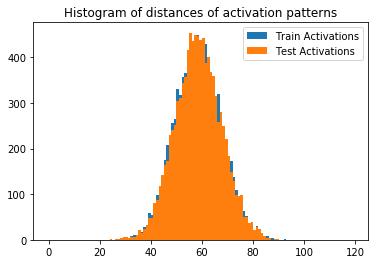

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.866535
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.826825
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.899904
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.823133
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.967018
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.825626
Train Epoch: 20 [38400/50000 (77%)]	Loss: 1.318147
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.992916

Test set: Average loss: 1.4763, Accuracy: 5164/10000 (52%)



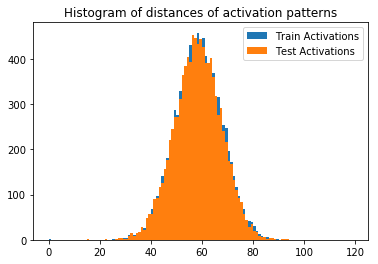

In [39]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    activation_metrics()